## Multivariate LSTM Forecast model for multiple outputs

### Distribution of the variables

            Tank_1       Tank_2       Tank_3       Pump_1       Pump_2  \
count  2420.000000  2420.000000  2420.000000  2420.000000  2420.000000   
mean    686.320661   714.946281   922.677686     0.300000     0.243802   
std     654.955181   656.051613   942.572849     0.458352     0.429463   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       2.000000     5.000000    73.250000     0.000000     0.000000   
50%     598.000000   639.500000   747.500000     0.000000     0.000000   
75%    1244.000000  1293.250000  1226.250000     1.000000     0.000000   
max    1980.000000  1952.000000  3427.000000     1.000000     1.000000   

       Flow_sensor_4  
count    2420.000000  
mean     1283.821488  
std      1738.336519  
min         0.000000  
25%         0.000000  
50%         0.000000  
75%      2769.000000  
max      4789.000000  


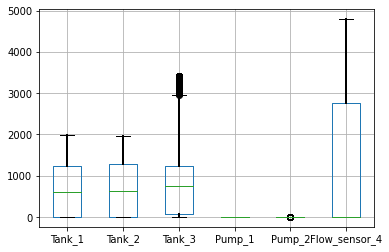

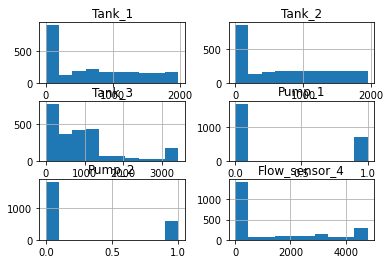

In [2]:
from matplotlib import pyplot
from pandas import read_csv
# load results file
# results = read_csv('phy_cps.csv', header=0)
results = read_csv('phy_cps.csv', header=0)
# descriptive stats
print(results.describe())
# box and whisker plot
results.boxplot(whiskerprops = dict(linestyle='-', linewidth=2))
pyplot.show()
# histogram
results.hist()
pyplot.show()

In [3]:
#from numpy import array
import keras
import numpy as np
from math import sqrt
import os, datetime
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error, r2_score
from keras.models import Sequential
from keras.layers import Dense
from keras.layers.core import Dropout
from keras.layers import LSTM
from keras.layers import *
import xlsxwriter

np.random.seed(17)

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

#load dataset
dataset = read_csv('phy_cps.csv', header=0, index_col=0)
values = dataset.values
 
#integer encode wind direction, as it's the only categorical variable.
#encoder = LabelEncoder()
#values[:,4] = encoder.fit_transform(values[:,4])
 
#ensure all data are float32 values
values = values.astype('float32')
 
#normalize input features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
 
#frame as supervised learning
n_hours = 1 
n_features = 6 
reframed = series_to_supervised(scaled, n_hours, 1)
values = reframed.values
# n_train_hours = 1936
n_train_hours = 1694
n_test = 484
train = values[:n_train_hours, :]
test = values[n_train_hours:n_train_hours+n_test, :]
out_test = values[n_train_hours+n_test:, :]
 

#split into input and outputs
n_obs = n_hours * n_features
train_X = train[:, :n_obs]
train_y = train[:, -n_features:(-n_features+4)] #+2 because of indexing madness.
test_X = test[:, :n_obs]
test_y = test[:, -n_features:(-n_features+4)]
 
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
 

#Need to output four values, not one.
#design network
model = Sequential()
model.add(LSTM(50, activation='relu',return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.1))
model.add(LSTM(20, activation='relu', return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(20, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(4))

model.compile(loss='mse', optimizer='adam')

# Create a Tensorboard logger
#logger = keras.callbacks.TensorBoard(log_dir='log', write_graph=True, histogram_freq=5)
logdir = os.path.join("mylog", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
logger = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

#fit network
# history = model.fit(train_X, train_y, epochs=200, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
history = model.fit(train_X, train_y, epochs=250, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False, callbacks=[logger])

# Plot history
pyplot.xlabel('Epochs')
pyplot.ylabel('Loss')
pyplot.title('Model Train vs Testing Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
 

#make a prediction
y_hat = model.predict(test_X)
print(f'The shape of y_hat is {y_hat.shape}')
#calculate RMSE - CHANGED to output RMSE for each variable.
norm_rmse_1 = sqrt(mean_squared_error(y_hat[:,0], test_y[:,0])) #RMSE for the first variable (Tank_1)
norm_rmse_2 = sqrt(mean_squared_error(y_hat[:,1], test_y[:,1])) #RMSE for the second variable (Tank_2)
norm_rmse_3 = sqrt(mean_squared_error(y_hat[:,2], test_y[:,2])) #RMSE for the third variable (Tank_3)
norm_rmse_4 = sqrt(mean_squared_error(y_hat[:,3], test_y[:,3])) #RMSE for the fourth variable (Pump_1)
print('Normalized Test RMSE: ', norm_rmse_1, norm_rmse_2, norm_rmse_3, norm_rmse_4)
    
test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))
inv_yhat = concatenate((y_hat, test_X[:,-2:]), axis=1) #changed 7 to 6
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0:4] #changed from 0 to 0:2. Should be first 2 columns that contain the predictions
 

#invert scaling for actual
test_y = test_y.reshape((len(test_y),4)) #changed 1 to 2
inv_y = concatenate((test_y, test_X[:,-2:]), axis=1) #changed 7 to 6
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0:4] #changed from 0 to 0:2. Should be first 2 columns that contain the predictions.
 

    
#calculate RMSE - CHANGED to output RMSE for each variable.
rmse_1 = sqrt(mean_squared_error(inv_y[:,0], inv_yhat[:,0])) #RMSE for the first variable (Tank_1)
rmse_2 = sqrt(mean_squared_error(inv_y[:,1], inv_yhat[:,1])) #RMSE for the second variable (Tank_2)
rmse_3 = sqrt(mean_squared_error(inv_y[:,2], inv_yhat[:,2])) #RMSE for the third variable (Tank_3)
rmse_4 = sqrt(mean_squared_error(inv_y[:,3], inv_yhat[:,3])) #RMSE for the fourth variable (Pump_1)

r_sq1 = r2_score(inv_y[:,0], inv_yhat[:,0])
r_sq2 = r2_score(inv_y[:,1], inv_yhat[:,1])
r_sq3 = r2_score(inv_y[:,2], inv_yhat[:,2])
r_sq4 = r2_score(inv_y[:,3], inv_yhat[:,3])

print('Test RMSE: ', rmse_1, rmse_2, rmse_3, rmse_4)

print("Test R-squared: ", r_sq1, r_sq2, r_sq3, r_sq4)
model.summary()

# Create file (workbook) and worksheet
outWorkbook = xlsxwriter.Workbook("out.xlsx")
outSheet = outWorkbook.add_worksheet()

# Declare data
values = [[rmse_1,norm_rmse_1,r_sq1],
          [rmse_2,norm_rmse_2,r_sq2],
          [rmse_3,norm_rmse_3,r_sq3],
          [rmse_4,norm_rmse_4,r_sq4]]

# Write headers
outSheet.write("C1", "Tank_1")
outSheet.write("D1", "Tank_2")
outSheet.write("E1", "Tank_3")
outSheet.write("F1", "Pump_1")

# Write data to file
outSheet.write("C2",values[0][0])
outSheet.write("C3",values[0][1])
outSheet.write("C4",values[0][2])

outSheet.write("D2",values[1][0])
outSheet.write("D3",values[1][1])
outSheet.write("D4",values[1][2])

outSheet.write("E2",values[2][0])
outSheet.write("E3",values[2][1])
outSheet.write("E4",values[2][2])

outSheet.write("F2",values[3][0])
outSheet.write("F3",values[3][1])
outSheet.write("F4",values[3][2])

outWorkbook.close()

# Save the model to disk
model.save('multi_lstm_model.h5')
print('Model saved to the disk')

ModuleNotFoundError: No module named 'xlsxwriter'

In [38]:
%tensorboard --logdir mylog

Reusing TensorBoard on port 6006 (pid 3200), started 19:59:37 ago. (Use '!kill 3200' to kill it.)

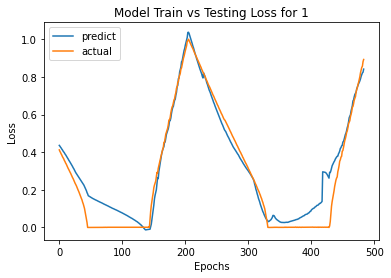

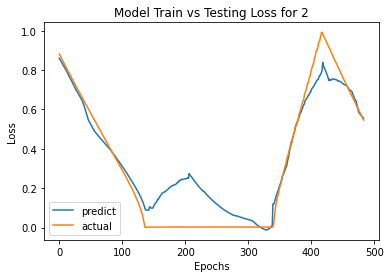

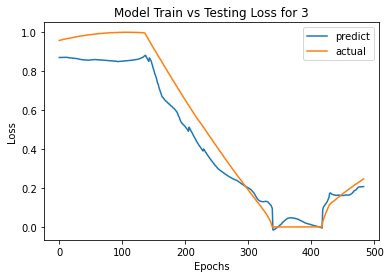

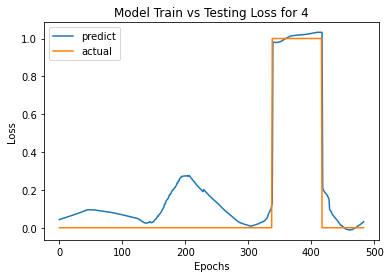

In [5]:
for i in range(4):
    pyplot.xlabel('Epochs')
    pyplot.ylabel('Loss')
    pyplot.title('Model Train vs Testing Loss for '+str(i+1))
    pyplot.plot(y_hat[:,i], label='predict')
    pyplot.plot(test_y[:,i], label='actual')
    pyplot.legend()
    pyplot.show()

In [6]:
from keras.models import load_model

model = load_model('multi_lstm_model.h5')

test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
yhat = model.predict(test_X)
#calculate RMSE - CHANGED to output RMSE for each variable.
# norm_rmse_1 = sqrt(mean_squared_error(y_hat[:241,0], test_y[:,0])) #RMSE for the first variable (Tank_1)
# norm_rmse_2 = sqrt(mean_squared_error(y_hat[:241,1], test_y[:,1])) #RMSE for the second variable (Tank_2)
# norm_rmse_3 = sqrt(mean_squared_error(y_hat[:241,2], test_y[:,2])) #RMSE for the third variable (Tank_3)
# norm_rmse_4 = sqrt(mean_squared_error(y_hat[:241,3], test_y[:,3])) #RMSE for the fourth variable (Pump_1)
norm_rmse_1 = sqrt(mean_squared_error(y_hat[:,0], test_y[:,0])) #RMSE for the first variable (Tank_1)
norm_rmse_2 = sqrt(mean_squared_error(y_hat[:,1], test_y[:,1])) #RMSE for the second variable (Tank_2)
norm_rmse_3 = sqrt(mean_squared_error(y_hat[:,2], test_y[:,2])) #RMSE for the third variable (Tank_3)
norm_rmse_4 = sqrt(mean_squared_error(y_hat[:,3], test_y[:,3])) #RMSE for the fourth variable (Pump_1)

print('Test RMSE: ', norm_rmse_1, norm_rmse_2, norm_rmse_3, norm_rmse_4)

ValueError: in user code:

    File "C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1801, in predict_function  *
        return step_function(self, iterator)
    File "C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1790, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1783, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1751, in predict_step
        return self(x, training=False)
    File "C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "sequential_8" is incompatible with the layer: expected shape=(None, 3, 6), found shape=(None, 1, 6)


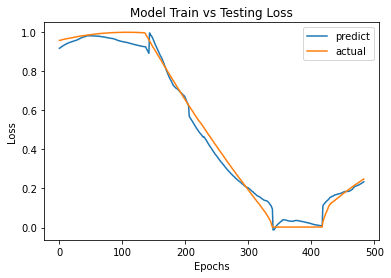

In [12]:
# Plot history
pyplot.xlabel('Epochs')
pyplot.ylabel('Loss')
pyplot.title('Model Train  vs Testing Loss')
pyplot.plot(yhat[:,2], label='predict')
pyplot.plot(test_y[:,2], label='actual')
pyplot.legend()
pyplot.show()

(484, 4)

### Box plot for rmse

           Tank_1      Tank_2      Tank_3     Pump_1
count   33.000000   33.000000   33.000000  33.000000
mean   144.161401  109.906095  134.719121   0.117114
std     29.680144   35.276328   34.676943   0.009327
min     88.629391   59.307521   74.722553   0.100214
25%    128.229447   79.751047  110.285824   0.109556
50%    142.568261  110.000502  126.947889   0.117160
75%    152.599295  128.335886  152.758458   0.124281
max    210.698327  197.403725  201.181122   0.132437


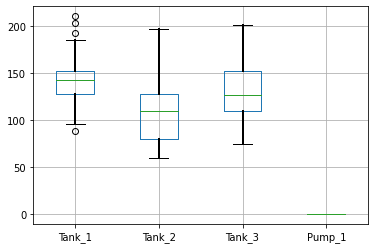

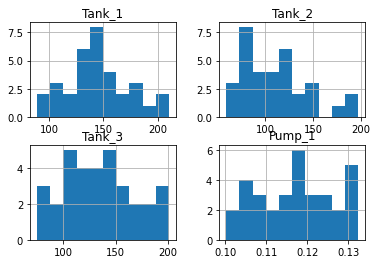

In [40]:
from pandas import DataFrame
from pandas import read_csv
from numpy import mean
from numpy import std
from matplotlib import pyplot
# load results file
results = read_csv('rmse_multiple_results.csv', header=0)
# descriptive stats
print(results.describe())
# box and whisker plot
results.boxplot(whiskerprops = dict(linestyle='-', linewidth=2))
pyplot.show()
# histogram
results.hist()
pyplot.show()

In [2]:
out_test.shape

(241, 12)

### Box plot for normalised rmse

          Tank_1     Tank_2     Tank_3     Pump_1
count  33.000000  33.000000  33.000000  33.000000
mean    0.072809   0.056304   0.039311   0.117114
std     0.014990   0.018072   0.010119   0.009327
min     0.044762   0.030383   0.021804   0.100214
25%     0.064762   0.040856   0.032181   0.109556
50%     0.072004   0.056353   0.037043   0.117160
75%     0.077070   0.065746   0.044575   0.124281
max     0.106413   0.101129   0.058705   0.132437


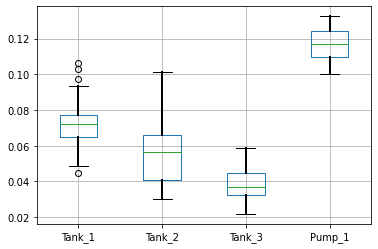

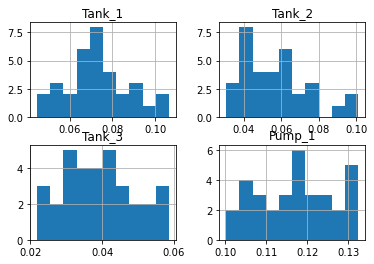

In [2]:
from pandas import DataFrame
from pandas import read_csv
from numpy import mean
from numpy import std
from matplotlib import pyplot
# load results file
results = read_csv('norm_rmse_multiple_results.csv', header=0)
# descriptive stats
print(results.describe())
# box and whisker plot
results.boxplot(whiskerprops = dict(linestyle='-', linewidth=2))
pyplot.show()
# histogram
results.hist()
pyplot.show()

### Box Plot for Coefficient of Determination (R-Squared )

          Tank_1     Tank_2     Tank_3     Pump_1
count  33.000000  33.000000  33.000000  33.000000
mean    0.942453   0.970305   0.910426   0.937769
std     0.023750   0.019602   0.044893   0.009843
min     0.881927   0.912903   0.812304   0.920907
25%     0.938065   0.963188   0.891784   0.930348
50%     0.945940   0.972955   0.925264   0.938101
75%     0.956268   0.985784   0.943595   0.945875
max     0.979108   0.992138   0.974107   0.954713


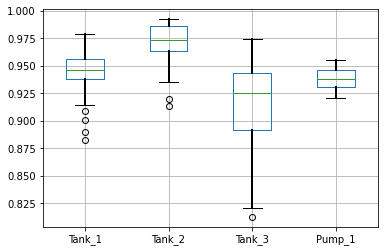

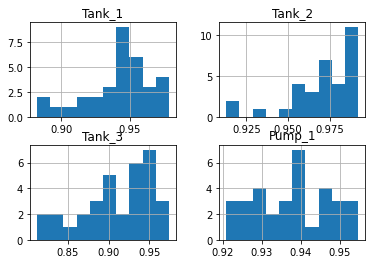

In [3]:
from pandas import DataFrame
from pandas import read_csv
from numpy import mean
from numpy import std
from matplotlib import pyplot
# load results file
results = read_csv('r_sq_multiple_results.csv', header=0)
# descriptive stats
print(results.describe())
# box and whisker plot
results.boxplot(whiskerprops = dict(linestyle='-', linewidth=2))
pyplot.show()
# histogram
results.hist()
pyplot.show()

### RMSE Function

In [9]:
import math
def rms(x,y):
    if len(x)!= len(y):
        return "The two inputs are incompatible"
    total = 0
    for i in range(len(x)):
        total += ((x[i]-y[i])**2)
    return math.sqrt(total/len(x))


p = [10,20,30,40,5]
q = [11,17,29,40]
print(rms(p,q))
val = [x for x in range(1000,10000,100)]
val2 = [k + 50 for k in val]
# del val2[3]
print(rms(val,val2))

The two inputs are incompatible
50.0


### Plot the prediction

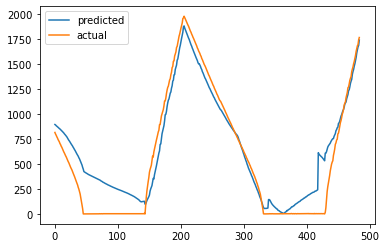

In [27]:
pyplot.plot(inv_yhat[0:500,0], label='predicted')
pyplot.plot(inv_y[0:500,0], label='actual')
pyplot.legend()
pyplot.show()

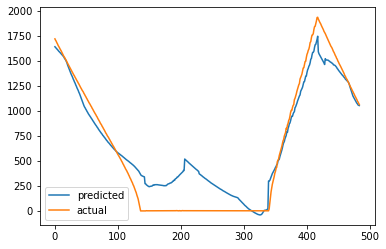

In [28]:
pyplot.plot(inv_yhat[0:500,1], label='predicted')
pyplot.plot(inv_y[0:500,1], label='actual')
pyplot.legend()
pyplot.show()

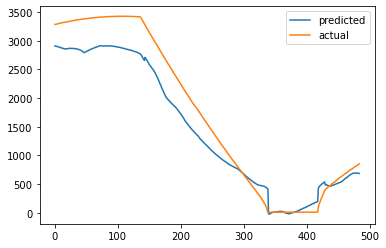

In [29]:
pyplot.plot(inv_yhat[0:500,2], label='predicted')
pyplot.plot(inv_y[0:500,2], label='actual')
pyplot.legend()
pyplot.show()

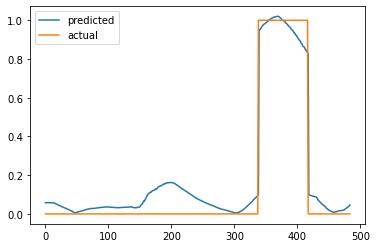

In [30]:
pyplot.plot(inv_yhat[0:500,3], label='predicted')
pyplot.plot(inv_y[0:500,3], label='actual')
pyplot.legend()
pyplot.show()

### Load saved model

In [1]:
from keras.models import load_model

model = load_model('multi_lstm_model.h5')

#split into input and outputs
# n_obs = n_hours * n_features

test_X = out_test[:, :n_obs]
test_y = out_test[:, -n_features:(-n_features+4)]

test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))

# Make a prediction
yhat = model.predict(test_X)

#calculate RMSE - CHANGED to output RMSE for each variable.
norm_rmse_1 = sqrt(mean_squared_error(y_hat[:241,0], test_y[:,0])) #RMSE for the first variable (Tank_1)
norm_rmse_2 = sqrt(mean_squared_error(y_hat[:241,1], test_y[:,1])) #RMSE for the second variable (Tank_2)
norm_rmse_3 = sqrt(mean_squared_error(y_hat[:241,2], test_y[:,2])) #RMSE for the third variable (Tank_3)
norm_rmse_4 = sqrt(mean_squared_error(y_hat[:241,3], test_y[:,3])) #RMSE for the fourth variable (Pump_1)
print('Test RMSE: ', norm_rmse_1, norm_rmse_2, norm_rmse_3, norm_rmse_4)
    
# test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))
# inv_yhat = concatenate((y_hat, test_X[:,-2:]), axis=1) #changed 7 to 6
# inv_yhat = scaler.inverse_transform(inv_yhat)
# inv_yhat = inv_yhat[:,0:4] #changed from 0 to 0:2. Should be first 2 columns that contain the predictions
 

# #invert scaling for actual
# test_y = test_y.reshape((len(test_y),4)) #changed 1 to 2
# inv_y = concatenate((test_y, test_X[:,-2:]), axis=1) #changed 7 to 6
# inv_y = scaler.inverse_transform(inv_y)
# inv_y = inv_y[:,0:4] #changed from 0 to 0:2. Should be first 2 columns that contain the predictions.
 

    
# #calculate RMSE - CHANGED to output RMSE for each variable.
# rmse_1 = sqrt(mean_squared_error(inv_y[:,0], inv_yhat[:,0])) #RMSE for the first variable (Tank_1)
# rmse_2 = sqrt(mean_squared_error(inv_y[:,1], inv_yhat[:,1])) #RMSE for the second variable (Tank_2)
# rmse_3 = sqrt(mean_squared_error(inv_y[:,2], inv_yhat[:,2])) #RMSE for the third variable (Tank_3)
# rmse_4 = sqrt(mean_squared_error(inv_y[:,3], inv_yhat[:,3])) #RMSE for the fourth variable (Pump_1)

# r_sq1 = r2_score(inv_y[:,0], inv_yhat[:,0])
# r_sq2 = r2_score(inv_y[:,1], inv_yhat[:,1])
# r_sq3 = r2_score(inv_y[:,2], inv_yhat[:,2])
# r_sq4 = r2_score(inv_y[:,3], inv_yhat[:,3])

# print('Test RMSE: ', rmse_1, rmse_2, rmse_3, rmse_4)

# print("Test R-squared: ", r_sq1, r_sq2, r_sq3, r_sq4)


KeyboardInterrupt: 

In [28]:
test_X.shape

(241, 1, 6)

### After injecting some faults in the model

In [30]:
import tensorflow as tf
model.summary()
#print(len(model.weights))
print(len(model.get_weights()))
new_model = tf.keras.models.clone_model(model)
new_model.pop()
new_model.summary()
model.save('faulty_lstm_model.h5')

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_33 (LSTM)              (None, 1, 50)             11400     
                                                                 
 dropout_33 (Dropout)        (None, 1, 50)             0         
                                                                 
 lstm_34 (LSTM)              (None, 1, 20)             5680      
                                                                 
 dropout_34 (Dropout)        (None, 1, 20)             0         
                                                                 
 lstm_35 (LSTM)              (None, 20)                3280      
                                                                 
 dropout_35 (Dropout)        (None, 20)                0         
                                                                 
 dense_11 (Dense)            (None, 4)               

In [34]:
from keras.models import load_model

# model = load_model('multi_lstm_model.h5')
model = load_model('faulty_lstm_model.h5')

#Injecting faults
#model.layers[0].filters *=2


test_X = out_test[:, :n_obs]
test_y = out_test[:, -n_features:(-n_features+4)]

test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))

# Make a prediction
y_hat = model.predict(test_X)

#calculate RMSE - CHANGED to output RMSE for each variable.
norm_rmse_1 = sqrt(mean_squared_error(y_hat[:241,0], test_y[:,0])) #RMSE for the first variable (Tank_1)
norm_rmse_2 = sqrt(mean_squared_error(y_hat[:241,1], test_y[:,1])) #RMSE for the second variable (Tank_2)
norm_rmse_3 = sqrt(mean_squared_error(y_hat[:241,2], test_y[:,2])) #RMSE for the third variable (Tank_3)
norm_rmse_4 = sqrt(mean_squared_error(y_hat[:241,3], test_y[:,3])) #RMSE for the fourth variable (Pump_1)
print('Test RMSE: ', norm_rmse_1, norm_rmse_2, norm_rmse_3, norm_rmse_4)
    
# test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))
# inv_yhat = concatenate((y_hat, test_X[:,-2:]), axis=1) #changed 7 to 6
# inv_yhat = scaler.inverse_transform(inv_yhat)
# inv_yhat = inv_yhat[:,0:4] #changed from 0 to 0:2. Should be first 2 columns that contain the predictions
 

# #invert scaling for actual
# test_y = test_y.reshape((len(test_y),4)) #changed 1 to 2
# inv_y = concatenate((test_y, test_X[:,-2:]), axis=1) #changed 7 to 6
# inv_y = scaler.inverse_transform(inv_y)
# inv_y = inv_y[:,0:4] #changed from 0 to 0:2. Should be first 2 columns that contain the predictions.
 

    
# #calculate RMSE - CHANGED to output RMSE for each variable.
# rmse_1 = sqrt(mean_squared_error(inv_y[:,0], inv_yhat[:,0])) #RMSE for the first variable (Tank_1)
# rmse_2 = sqrt(mean_squared_error(inv_y[:,1], inv_yhat[:,1])) #RMSE for the second variable (Tank_2)
# rmse_3 = sqrt(mean_squared_error(inv_y[:,2], inv_yhat[:,2])) #RMSE for the third variable (Tank_3)
# rmse_4 = sqrt(mean_squared_error(inv_y[:,3], inv_yhat[:,3])) #RMSE for the fourth variable (Pump_1)

# r_sq1 = r2_score(inv_y[:,0], inv_yhat[:,0])
# r_sq2 = r2_score(inv_y[:,1], inv_yhat[:,1])
# r_sq3 = r2_score(inv_y[:,2], inv_yhat[:,2])
# r_sq4 = r2_score(inv_y[:,3], inv_yhat[:,3])

# print('Test RMSE: ', rmse_1, rmse_2, rmse_3, rmse_4)

# print("Test R-squared: ", r_sq1, r_sq2, r_sq3, r_sq4)


Test RMSE:  0.08614524742897423 0.06842594311518578 0.041183177696781516 0.08832120328890113


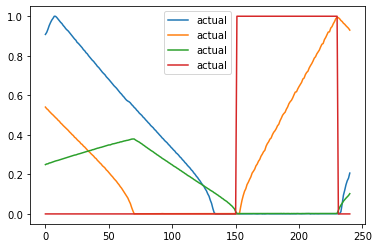

In [19]:
pyplot.plot(test_y[:,], label='actual')
pyplot.legend()
pyplot.show()

In [1]:
print("Begin")

Begin
